In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import sem


from scipy.stats import f_oneway
from scikit_posthocs import posthoc_tukey

%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def generate_heatmap(data_heatmap, lengthsize):
    """Heatmap of a dataframe from post hoc test of scikit_posthoc"""
    colors = ['darkgreen', 'green', 'lightgreen', 'grey']
    thresholds = [0, 0.001, 0.01, 0.05, 1]  # Set the thresholds for each color

    custom_cmap = mpl.colors.ListedColormap(colors)
    bounds = [thresholds[0]] + thresholds[1:-1] + [thresholds[-1]]
    norm = mpl.colors.BoundaryNorm(bounds, custom_cmap.N)

    mask = np.triu(np.ones_like(data_heatmap, dtype=bool))

    annot_kws = {"size": lengthsize + 3}  # Adjust the size as per your requirement
    fig, ax = plt.subplots(figsize=(lengthsize, lengthsize * 0.75), dpi=200)

    heatmap = sns.heatmap(data_heatmap, cmap=custom_cmap, norm=norm, mask=mask,
                          annot=True, vmin=0, vmax=1, annot_kws=annot_kws)
    heatmap.set_title('Heatmap', fontdict={'fontsize': lengthsize * 3.2}, pad=16)
    ax.tick_params(axis='both', which='major', labelsize=lengthsize * 3)
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.show()

# Loading df

In [3]:
df = pd.read_csv('data/gh2ax loci count all.csv')
df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,IntDen,tto,data
0,controle 1 - dapi - pfak - gamma - 1_Out-1.czi...,2,2.294,1.147,0.562,255.0,292.522,ct,2020_06_09
1,controle 1 - dapi - pfak - gamma - 2_Out-1.czi...,29,8.267,0.285,0.959,255.0,72.688,ct,2020_06_10
2,controle 1 - dapi - pfak - gamma - 3_Out-1.czi...,24,5.385,0.224,1.071,255.0,57.214,ct,2020_06_11
3,controle 2 - dapi - pfak - gamma - 1_Out-1.czi...,3,0.782,0.261,0.209,255.0,66.448,ct,2020_06_12
4,controle 2 - dapi - pfak - gamma - 2_Out-1.czi...,9,3.921,0.436,1.120,255.0,111.100,ct,2020_06_13


# Aggregations

In [4]:

tto_list = ['ct_sc', 'ct_sifak', 'dox_sc', 'dox_sifak']
df_slice = df[df['tto'].isin(tto_list)]
df_sifak = df_slice[['tto', 'Count']]
sifak_agg = df_sifak.groupby('tto').agg({'Count': [np.mean, np.std, 'sem', 'count']})

#gh2ax foci counts
ct_sc = df_sifak[df_sifak['tto']=='ct_sc']['Count']
ct_sifak = df_sifak[df_sifak['tto']=='ct_sifak']['Count']
dox_sc = df_sifak[df_sifak['tto']=='dox_sc']['Count']
dox_sifak = df_sifak[df_sifak['tto']=='dox_sifak']['Count']

In [5]:
sifak_agg

Count                           
                mean        std       sem count
tto                                            
ct_sc       3.183673   1.844739  0.263534    49
ct_sifak    6.705882   5.397385  0.755785    51
dox_sc     52.864865  17.472458  2.872454    37
dox_sifak  49.047619  17.655169  2.724252    42

# Checando normalidade

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

def teste_normalidade(x):
    # Plotting the histogram with KDE line
    plt.subplot(1, 2, 1)
    plt.rcParams["figure.figsize"] = (8, 4)
    ax = sns.histplot(x, kde=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='x', width=0.5, color='gray')
    ax.tick_params(axis='y', width=0.5, color='gray')

    # Plotting the QQ-plot
    plt.subplot(1, 2, 2)
    pg.qqplot(x, dist='norm')
    
    # Calculating skewness and kurtosis
    print('Sample size:', len(x))
    print('Skewness:', stats.skew(x), '(The farther from zero, the less normal)')
    print('Kurtosis:', stats.kurtosis(x))

    # Shapiro-Wilk test (may not work well with many identical values)
    W, p = stats.shapiro(x)
    print('Shapiro-Wilk: W={0}, p={1}'.format(W, p), '(if p > 0.05, it is normal)')

    # Kolmogorov-Smirnov test
    D, p = stats.kstest(x, cdf='norm', args=(x.mean(), x.std()), N=len(x))
    print('Kolmogorov-Smirnov: D={0}, p={1}'.format(D, p), '(if p > 0.05, it is normal)')

    # Anderson-Darling test
    ad_stat, ad_critical, ad_theoretical = stats.anderson(x, dist='norm')
    print('Anderson-Darling: T={0}, p(0.05)={1}'.format(ad_stat, ad_critical[2]), '(if p > 0.05, it is normal)')
    print('Anderson-Darling critical values:', ad_critical)
    print('Anderson-Darling percentages:', ad_theoretical)

Sample size: 49
Skewness: 1.2362080825396928 (The farther from zero, the less normal)
Kurtosis: 2.2760722337481916
Shapiro-Wilk: W=0.8927633762359619, p=0.00032155567896552384 (if p > 0.05, it is normal)
Kolmogorov-Smirnov: D=0.21312498831982557, p=0.019695618693309935 (if p > 0.05, it is normal)
Anderson-Darling: T=1.733459001076703, p(0.05)=0.735 (if p > 0.05, it is normal)
Anderson-Darling critical values: [0.538 0.612 0.735 0.857 1.019]
Anderson-Darling percentages: [15.  10.   5.   2.5  1. ]


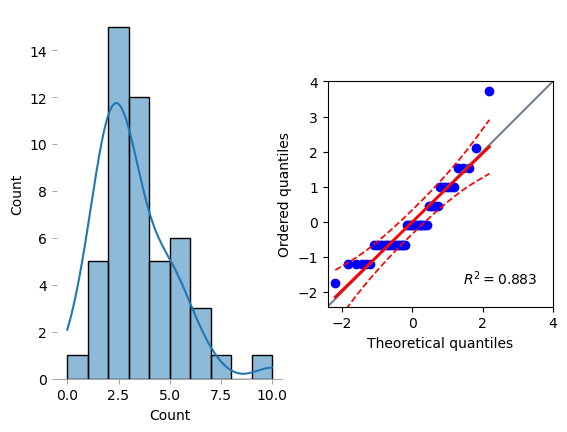

In [7]:
teste_normalidade(ct_sc)

Sample size: 51
Skewness: 1.2023574079079824 (The farther from zero, the less normal)
Kurtosis: 1.7809419773652477
Shapiro-Wilk: W=0.8971706032752991, p=0.0003388281329534948 (if p > 0.05, it is normal)
Kolmogorov-Smirnov: D=0.13382437308408068, p=0.2936630057899483 (if p > 0.05, it is normal)
Anderson-Darling: T=1.2692025214793645, p(0.05)=0.736 (if p > 0.05, it is normal)
Anderson-Darling critical values: [0.539 0.614 0.736 0.859 1.022]
Anderson-Darling percentages: [15.  10.   5.   2.5  1. ]


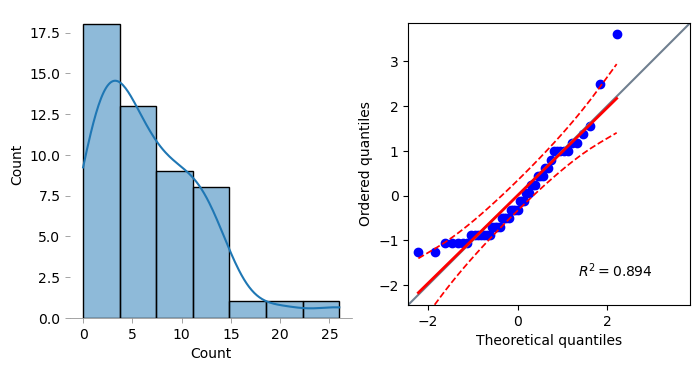

In [8]:
teste_normalidade(ct_sifak)

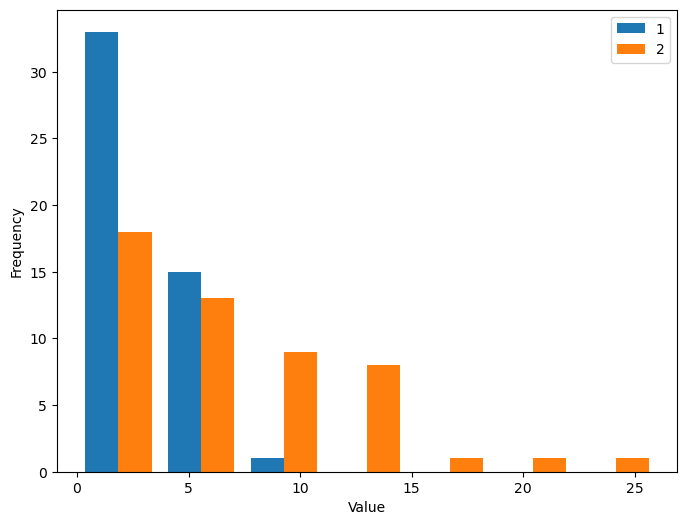

In [9]:
def plot_2histograms(x, y):
    plt.figure(figsize=(8, 6))
    plt.hist([x, y], bins=7, label= [1,2])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
    
plot_2histograms(ct_sc, ct_sifak)

# Non-Dox SiScramble RNA and Non-Dox SiFAK RNA are not Symmetric distributed

Hypothesis: The treatment change the quantity of gh2ax foci in the nucleus cell?

- H0: No diference
- H1: the groups are different

Mann-whitney U test between the two is the best in this option:

- Non-Normal distributed
- Continuos data type
- Similar distribution
- Independent variable ( the cells are independent from each other groups)


In [10]:
def mwu_test(controle, tratamento):
    stat, p = stats.mannwhitneyu(controle, tratamento)
    print('t=%.3f, p=%.5f' % (stat, p))
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    return "NS"

mwu_test(ct_sc, ct_sifak)

t=767.500, p=0.00081


'***'

## If the robustness of T-test is enough for not required normally distributions

In [11]:
def ttest(controle, tratamento):
    stat, p = stats.ttest_ind(controle, tratamento)
    print('t=%.3f, p=%.5f' % (stat, p))
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    return "NS"

ttest(ct_sc, ct_sifak)

t=-4.331, p=0.00004


'****'

# Checando normalidade dos tratados com Dox

Sample size: 37
Skewness: 0.24219080821337682 (The farther from zero, the less normal)
Kurtosis: 0.4870403442807909
Shapiro-Wilk: W=0.9743180274963379, p=0.5373244285583496 (if p > 0.05, it is normal)
Kolmogorov-Smirnov: D=0.09572171442983024, p=0.854971599959664 (if p > 0.05, it is normal)
Anderson-Darling: T=0.3741119769711645, p(0.05)=0.722 (if p > 0.05, it is normal)
Anderson-Darling critical values: [0.529 0.602 0.722 0.842 1.002]
Anderson-Darling percentages: [15.  10.   5.   2.5  1. ]


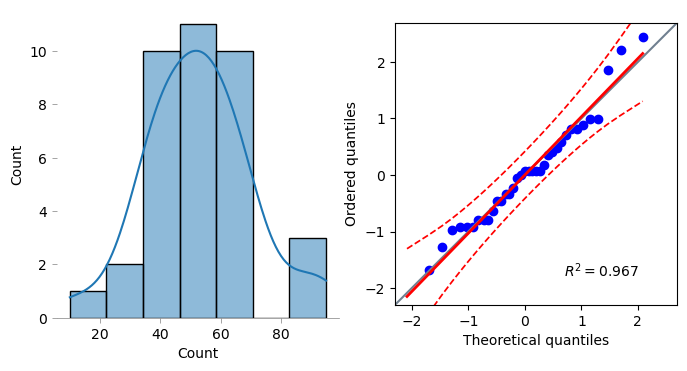

In [12]:
teste_normalidade(dox_sc)

Sample size: 42
Skewness: 0.021586659539371503 (The farther from zero, the less normal)
Kurtosis: -0.6218063973499168
Shapiro-Wilk: W=0.9538031816482544, p=0.08844207972288132 (if p > 0.05, it is normal)
Kolmogorov-Smirnov: D=0.1361880163292874, p=0.38262676435313203 (if p > 0.05, it is normal)
Anderson-Darling: T=0.8609830377876904, p(0.05)=0.728 (if p > 0.05, it is normal)
Anderson-Darling critical values: [0.533 0.607 0.728 0.849 1.01 ]
Anderson-Darling percentages: [15.  10.   5.   2.5  1. ]


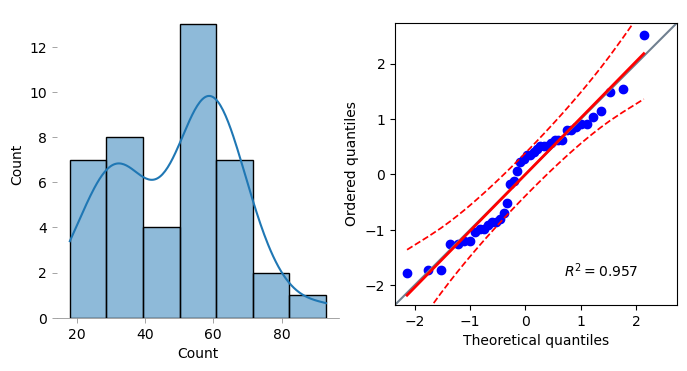

In [13]:
teste_normalidade(dox_sifak)

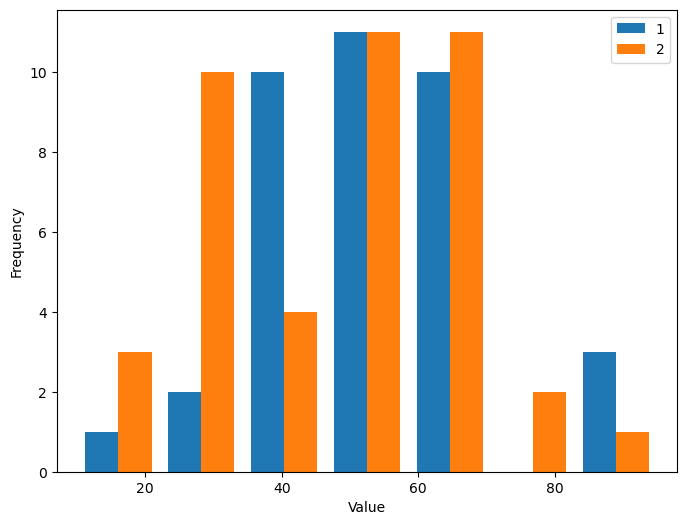

In [14]:
plot_2histograms(dox_sc, dox_sifak)

# Dox SiScramble RNA and Dox SiFAK RNA are "more" Symmetric distributed
T-test test between the two is the best in this option:

- Normal distributed (by Shapiro-Wilk normality test)
- Continuos data type
- Similar distribution

In [15]:
ttest(dox_sc, dox_sifak)

t=0.964, p=0.33827


'NS'

# 4 distribuições: 2 normais, 2 não normais.

- Non-normal distribution (must use non-parametric)
- independent samples
- nominal + metric variable

Kruskal-Wallis is the chosen test method

There difference between all the groups?

[good source](https://www.youtube.com/watch?v=l86wEhUzkY4)

In [16]:
from scipy.stats import kruskal


# Create an empty dictionary to store the arrays for each 'tto' group
count_arrays = {}

# Iterate over each 'tto' group
for tto_group, group_df in df_sifak.groupby('tto'):
    count_arrays[tto_group] = group_df['Count'].values

count_values = list(count_arrays.values())

#  Kruskal-Willis
f_statistic, p_value = kruskal(*count_values)

print("Kruskal results:")
print("F-statistic:", f_statistic)
print("rounded p-value:", format(p_value, '.4f'))  # Round p-value to 4 decimals after the comma
print("p-value:", p_value)


Kruskal results:
F-statistic: 134.4338878283344
rounded p-value: 0.0000
p-value: 5.990207342314148e-29


# Post-Hoc to look beetween groups

The Conover-Iman test likewise preserves the ranks that the Kruskal-Wallis uses, and uses a pooled variance estimate to construct post hoc t test statistics. This test is valid if and only if you reject the Kruskal-Wallis test, but provides uniformly greater power to reject the null than Dunn's test. ([source](https://stackoverflow.com/questions/31434166/which-post-hoc-test-should-i-conduct-after-doing-a-kruskal-wallis))

[another good source](https://web.pdx.edu/~newsomj/uvclass/ho_posthoc.pdf)

[another good source²](https://stats.stackexchange.com/questions/111869/can-mann-whitney-test-be-used-for-post-hoc-comparisons-after-kruskal-wallis?rq=1)

In [17]:
from scikit_posthocs import posthoc_dunn
dunn_df = posthoc_dunn(df_sifak, val_col="Count", group_col="tto")
dunn_df.round(3)

,ct_sc,ct_sifak,dox_sc,dox_sifak
ct_sc,1.000,0.057,0.000,0.000
ct_sifak,0.057,1.000,0.000,0.000
dox_sc,0.000,0.000,1.000,0.755
dox_sifak,0.000,0.000,0.755,1.000


In [18]:
from scikit_posthocs import posthoc_mannwhitney

mannwhitney_df = posthoc_mannwhitney(df_sifak, val_col="Count", group_col="tto")
mannwhitney_df.round(4)

,ct_sc,ct_sifak,dox_sc,dox_sifak
ct_sc,1.0000,0.0008,0.000,0.000
ct_sifak,0.0008,1.0000,0.000,0.000
dox_sc,0.0000,0.0000,1.000,0.455
dox_sifak,0.0000,0.0000,0.455,1.000


In [19]:
from scikit_posthocs import posthoc_conover

conover_df = posthoc_conover(df_sifak, val_col="Count", group_col="tto")
conover_df.round(4)

,ct_sc,ct_sifak,dox_sc,dox_sifak
ct_sc,1.0000,0.0002,0.0000,0.0000
ct_sifak,0.0002,1.0000,0.0000,0.0000
dox_sc,0.0000,0.0000,1.0000,0.5325
dox_sifak,0.0000,0.0000,0.5325,1.0000


In [20]:
from scikit_posthocs import posthoc_nemenyi
nemenyi_df = posthoc_nemenyi(df_sifak, val_col="Count", group_col="tto")
nemenyi_df.round(4)

,ct_sc,ct_sifak,dox_sc,dox_sifak
ct_sc,1.0000,0.3065,0.0000,0.0000
ct_sifak,0.3065,1.0000,0.0000,0.0000
dox_sc,0.0000,0.0000,1.0000,0.9921
dox_sifak,0.0000,0.0000,0.9921,1.0000


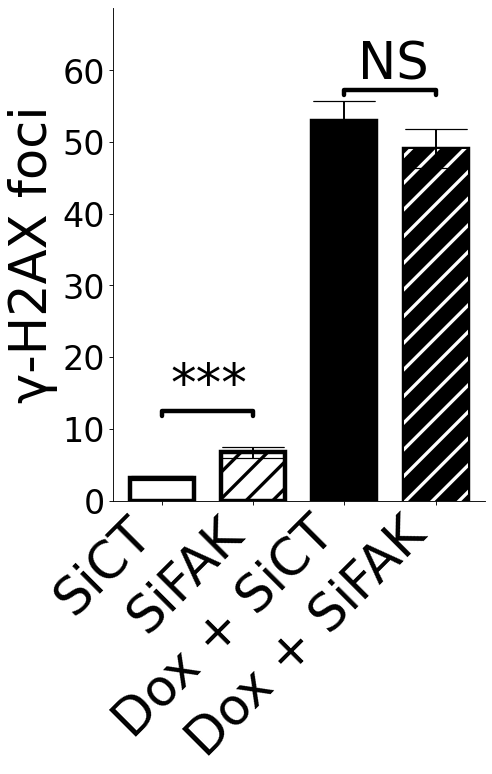

In [21]:
# dados

grupos = [ct_sc, ct_sifak, dox_sc, dox_sifak]
means = sifak_agg['Count']['mean']
erros = sifak_agg['Count']['sem']

# Set the figure filename
figure_name = 'sifak gh2ax loci countmean kruskal-conover'

cores_barras = ['white', 'white', 'black', 'black']
cor_envolta = ["black", 'white'] #cor da linha envolta das barras
espessura_volta = 4   #espessura da linha envolta das barras
tamanho_barra_erro = 30           #tamanho da barra horizontal de erro

# coisas relacionadas ao eixo Y
Eixo_Y = 'γ-H2AX foci' # O que vai aparecer escrito no eixo Y
Tamanho_label_Y = 46 # Tamanho do texto do eixo Y
Tamanho_ticks_Y = 30 # Tamanho dos números que aparecem no eixo Y

# coisas relacionadas ao eixo X
labels = ['SiCT', 'SiFAK', 'Dox + SiCT', 'Dox + SiFAK'] #o que vai aparecer embaixo das barras, no eixo X.
Tamanho_label_X = 46 # Tamanho do texto do eixo X

# remover normalização
means_normalizado = means
erros_normalizado = erros

def traco(text,X,Y,barhight,texthight,xtext):
    x = (X[0]+X[1])/2
    y = 1.295* max(Y[0], Y[1])+barhight #caso o traço esteja no lugar errado, é aqui onde arruma, no valor antes da multiplicação
    dx = abs(X[0]-X[1])
    yp = y 
    xp = x+xtext # caso você achar que o asterísco não esta no lugar certo, altere o valor que é subtraido do x até que ele apareça onde é desejado
       
    props = {'connectionstyle':'bar','arrowstyle':'-',\
            'shrinkA':20,'shrinkB':20,'linewidth':4,'color':"black"}
    ax.annotate(text,fontsize =46, xy=(xp,yp+0.1*max(means_normalizado)+texthight), zorder=10,color="#000000")
    ax.annotate('', xy=(X[0],y), xytext=(X[1],y), arrowprops=props)

# gráfico #########################################   

plt.rcParams['hatch.linewidth'] = 3 # regula a espessura das linhas dentro das barras

x = [1, 2, 3, 4]  # localização da barra
width = 0.7# espessura da barra

fig, ax = plt.subplots(figsize=(6,8), dpi=80)
barra_1 = ax.bar(x[0], means_normalizado[0],yerr=erros_normalizado[0],  capsize =28, width= width, color= cores_barras[0] ,edgecolor= cor_envolta, linewidth= espessura_volta, label= labels[0])
barra_2 = ax.bar(x[1], means_normalizado[1],yerr=erros_normalizado[1],  capsize =28, width= width, color= cores_barras[1] ,edgecolor= cor_envolta, linewidth= espessura_volta, label= labels[1])
barra_3 = ax.bar(x[2], means_normalizado[2],yerr=erros_normalizado[2],  capsize =28, width= width, color= cores_barras[2] ,edgecolor= cor_envolta, linewidth= espessura_volta, label= labels[2])
barra_4 = ax.bar(x[3], means_normalizado[3],yerr=erros_normalizado[3],  capsize =28, width= width, color= cores_barras[3] ,edgecolor= cor_envolta, linewidth= espessura_volta, label= labels[3])

barra_1 = ax.bar(x[0], means_normalizado[0],yerr=erros_normalizado[0],  capsize =28, width= width, color= 'None', hatch='',edgecolor= cor_envolta, linewidth= 0, label= labels[0])
barra_2 = ax.bar(x[1], means_normalizado[1],yerr=erros_normalizado[1],  capsize =28, width= width, color= 'None', hatch='/'*1,edgecolor= cor_envolta, linewidth= 0, label= labels[1])
barra_3 = ax.bar(x[2], means_normalizado[2],yerr=erros_normalizado[2],  capsize =28, width= width, color= 'None', hatch='',edgecolor= cor_envolta[1], linewidth= 0, label= labels[2])
barra_4 = ax.bar(x[3], means_normalizado[3],yerr=erros_normalizado[3],  capsize =28, width= width, color= 'None', hatch='/'*1,edgecolor= cor_envolta[1], linewidth= 0, label= labels[3])

# chamando def para os traços

traco("***",x[0:2],means_normalizado[0:2],0,-.1,-.4)
# traco(ttesting(grupos[1],grupos[2]), (x[1], x[2]), (means_normalizado[1],means_normalizado[2]), 1, -1,-.55)
traco("NS",x[2:4],means_normalizado[2:4],-15,0,-.35)
# traco(ttesting(grupos[0],grupos[3]), (x[0], x[3]), (means_normalizado[0],means_normalizado[3]), 2, 2.5,-.5)

plt.ylim(0,1.3* max(means_normalizado))
ax.set_ylabel(Eixo_Y,fontsize=Tamanho_label_Y)
plt.yticks(fontsize=Tamanho_ticks_Y)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=Tamanho_label_X, rotation=45, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the figure in PDF, JPEG, and PNG formats
plt.savefig(f'{figure_name}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'{figure_name}.jpeg', bbox_inches='tight', dpi=300)
plt.savefig(f'{figure_name}.png', bbox_inches='tight', dpi=300, transparent=True)


plt.show()